In [1]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
npPath = '/sharedData/scratch/all_npy3/'
ncPath = '/sharedData/scratch/'
acmPath = '/sharedData/scratch/ACMFiles/'
import re
import os
from os import path as op
import numpy as np

In [2]:
#day = '103'
#band = '08'

def getTmean(SS, npPath, band, day):
   
    ncList = os.listdir( ncPath )
    npList = os.listdir( npPath )
    acmList = os.listdir( acmPath )
    
    look = 'M6C'+ band + '_G' + SS + '_s2019' + day
    acmLook = 'M6_G' + SS + '_s2019' + day
    
    ncFiles = sorted([f for f in ncList if re.search(look,f)])
    npFiles = sorted([f for f in npList if re.search(look,f)])
    acmFiles = sorted([f for f in acmList if re.search(acmLook,f)])
    plot = createPlotArray(ncFiles,npFiles,npPath,acmFiles)
    return plot


In [3]:
def Rad2BT(rad, planck_fk1, planck_fk2, planck_bc1, planck_bc2):
    """Radiances to Brightness Temprature (using black body equation)"""
    invRad = np.array(rad)**(-1)
    arg = (invRad*planck_fk1) + 1.0
    T = (- planck_bc1+(planck_fk2 * (np.log(arg)**(-1))) )*(1/planck_bc2) 
    return T

In [4]:
def createPlotArray(ncFiles,npFiles,npPath,acmFiles):
    Tmean= []
    times = []
    for ncf, npf, acm in zip(ncFiles, npFiles, acmFiles):
        imageBox = np.load(op.join(npPath,npf))
        acmBox = np.load(op.join(acmPath,acm))
        myFile = xr.open_dataset(op.join(ncPath,ncf))
        planck_fk1 = float(myFile['planck_fk1'].data)
        planck_fk2 = float(myFile['planck_fk2'].data) 
        planck_bc1 = float(myFile['planck_bc1'].data)                       
        planck_bc2 = float(myFile['planck_bc2'].data)     
        T = Rad2BT(imageBox[acmBox==1].mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
        tString = ncf[34:38]
        times.append(tString)
        Tmean.append(T)
    return times, Tmean
    

In [5]:
import matplotlib.dates as mdates
from datetime import datetime

In [6]:
times17, mean17 = getTmean('17',npPath, band ='07', day = '103')
times16, mean16 = getTmean('16',npPath, band ='07', day = '103')


ptimes17 = [datetime.strptime(f"2019{day}{t}", "%Y%j%H%M") for t in times17]
ptimes16 = [datetime.strptime(f"2019{day}{t}", "%Y%j%H%M") for t in times16]

fig, ax = plt.subplots(figsize=(15,5), constrained_layout=True)
_ = ax.plot_date(ptimes17, mean17 , label="GOES-17", color='tab:blue',marker='+', markersize = 16)
_ = ax.plot_date(ptimes16, mean16 , label='GOES-16', color='tab:red', marker='+', markersize = 16, zorder=-1)
_ = ax.set_ylim(220,260)
_ = ax.tick_params('both', labelsize=18)
_ = ax.legend()
_ = ax.set_title('Filtered Clear Sky \n Mean Temperatures (K) for a 401 x 1001 Portion\n of Band 08 on 04-13-2019', fontweight ='bold', fontsize = 22)
_ = ax.set_ylabel('Temperature (K)',fontsize = 16)
_ = ax.set_xlabel('time (hours)',fontsize = 16)
_ = ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))





FileNotFoundError: [Errno 2] No such file or directory: '/sharedData/scratch/'

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


144
144


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


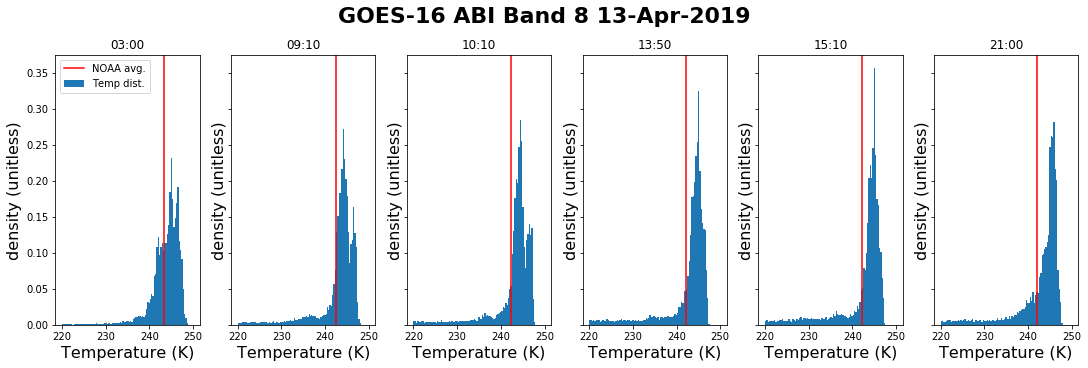

In [22]:
Tmean = []
times = []
toi = ['0300','0910','1010','1350','1510','2100']
SS = '16'
bins = np.linspace(220,250,101)
fig, axes = plt.subplots(ncols=6, nrows =1, figsize=(15, 5), constrained_layout=True, sharey = True, sharex = True)
fig.suptitle(f'GOES-{SS} ABI Band 8 13-Apr-2019', fontsize = 22, fontweight = 'bold')
lookup = f'M6C08_G{SS}_s2019103'
ncFiles = [f for f in os.listdir(ncPath) if re.search(lookup,f)]
npFiles = [f for f in os.listdir(npPath_16) if re.search(lookup,f)]
print(len(ncFiles))
print(len(npFiles))
for ncf, npf in zip(ncFiles,npFiles):
    imageBox = np.load(op.join(npPath_16,npf))
    myFile = xr.open_dataset(op.join(ncPath,ncf))
    planck_fk1 = float(myFile['planck_fk1'].data)
    planck_fk2 = float(myFile['planck_fk2'].data) 
    planck_bc1 = float(myFile['planck_bc1'].data)                       
    planck_bc2 = float(myFile['planck_bc2'].data)     
    T = Rad2BT(imageBox.mean(), planck_fk1, planck_fk2, planck_bc1, planck_bc2)
    tString = ncf[34:38]
    times.append(tString)
    Tmean.append(T)

    if tString in toi:
        ax = axes[toi.index(tString)]
        hh = tString[:2]
        mm = tString[2:4]
        ax.set_title(f'{hh}:{mm}')
        ax.set_ylabel('density (unitless)',fontsize = 16)
        ax.set_xlabel('Temperature (K)', fontsize = 16)
     
        Tbox = Rad2BT(imageBox, planck_fk1, planck_fk2, planck_bc1, planck_bc2)
        ax.hist(Tbox.ravel(), bins = bins, density = True, label = 'Temp dist.')
        #ax.plot([T,T], [0,0.3],'r', label = 'something')
        ax.axvline(T, color='r',label = 'NOAA avg.')
    axes[0].legend(loc='upper left')
#fig.savefig("")

In [91]:
a=[12.34,66, 77]


In [92]:
a.index(12.34)

0

In [202]:
ACM_File = xr.open_dataset(op.join(cloudPath,'OR_ABI-L2-ACMF-M6_G17_s20191032350339_e20191032359405_c20191032359587.nc'))

In [208]:
print(ACM_File['BCM'])

<xarray.DataArray 'BCM' (y: 5424, x: 5424)>
[29419776 values with dtype=float32]
Coordinates:
    t                                datetime64[ns] ...
  * y                                (y) float32 0.151844 0.151788 ... -0.151844
  * x                                (x) float32 -0.151844 ... 0.151844
    y_image                          float32 ...
    x_image                          float32 ...
    retrieval_local_zenith_angle     float32 ...
    quantitative_local_zenith_angle  float32 ...
    retrieval_solar_zenith_angle     float32 ...
    twilight_solar_zenith_angle      float32 ...
Attributes:
    long_name:                         ABI L2+ Clear Sky Mask
    standard_name:                     cloud_binary_mask
    valid_range:                       [0 1]
    units:                             1
    resolution:                        y: 0.000056 rad x: 0.000056 rad
    grid_mapping:                      goes_imager_projection
    cell_methods:                      retrieval_loca

In [207]:
print(ACM_File['BCM'].shape)

(5424, 5424)


In [209]:
G16_File = xr.open_dataset(op.join(ncPath,'OR_ABI-L1b-RadF-M6C07_G16_s20191030000200_e20191030009519_c20191030009557.nc'))

In [212]:
print(G16_File['Rad'].shape)

(5424, 5424)


In [217]:
print(sum(sum(ACM_File['BCM'].data==0)))

7285858


In [221]:
print((ACM_File['BCM'].data==0).ravel().sum())

7285858


In [222]:
G16_array = G16_File['Rad'].data
ACM_Bool = ACM_File['BCM'].data==0

In [226]:
clear16 = G16_array[ACM_Bool]

In [230]:
len(clear16)

7285858

In [228]:
print (clear16)

[0.08285503 0.08441938 0.08441938 ... 0.07034022 0.07346892 0.07972632]


In [232]:
clearMean = clear16.mean()

In [233]:
print(clearMean)

0.5792133


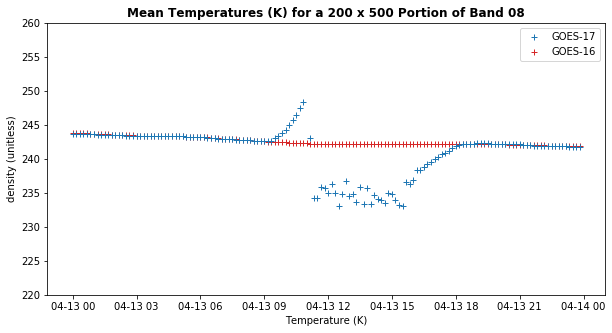

In [235]:
fig, ax1 = plt.subplots(figsize=(10,5))
_ = ax1.plot_date(ptimes, getTmean('17'), label="GOES-17", marker='+')
_ = ax1.plot_date(ptimes, getTmean('16'), label='GOES-16', color='tab:red', marker='+', zorder=-1)
_ = ax1.set_ylim(220,260)
_ = ax1.legend()
_ = ax1.set_title('Mean Temperatures (K) for a 200 x 500 Portion of Band 08', fontweight ='bold')
_ = ax1.set_ylabel('Temperature (unitless)')
_ = ax1.set_xlabel('Temperature (K)')
#fontsize

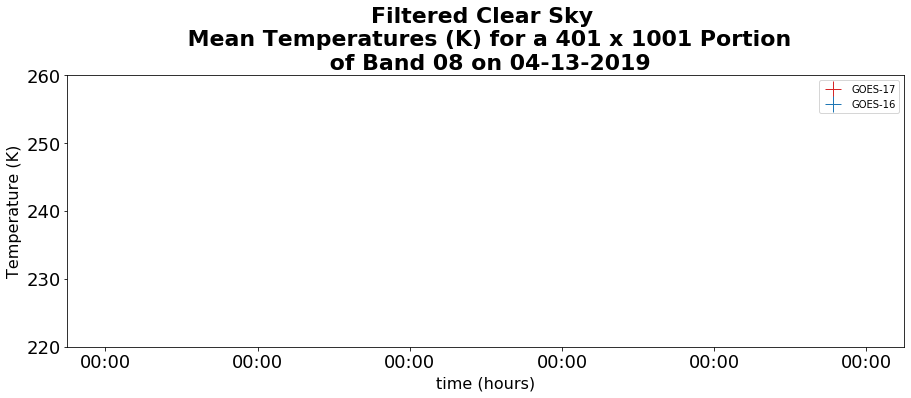

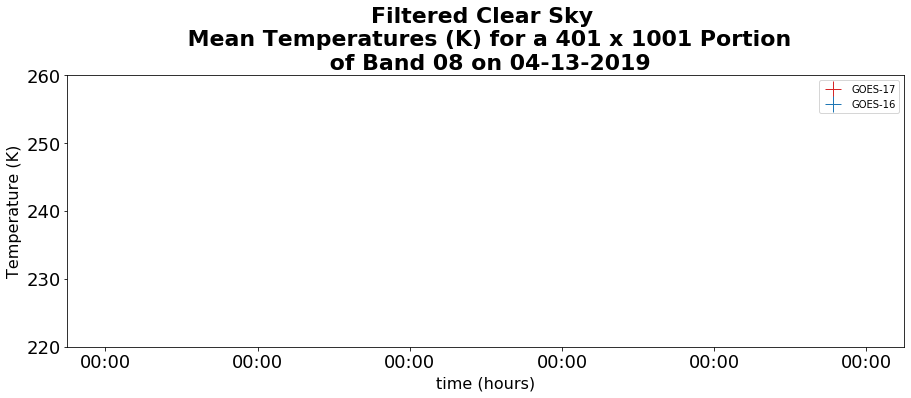

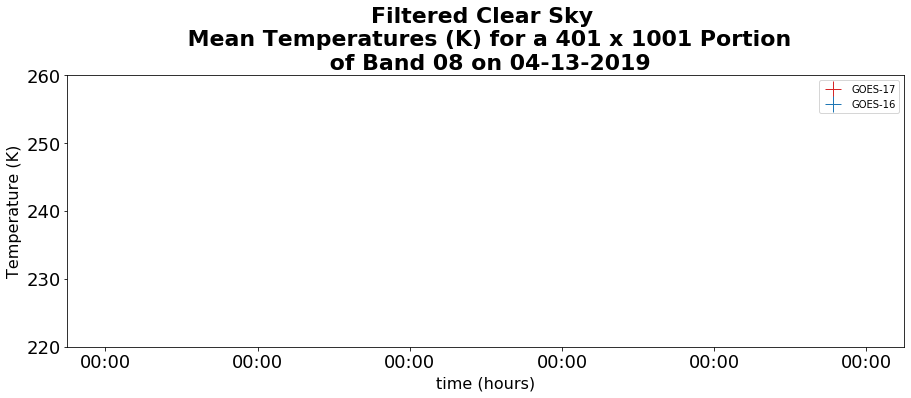

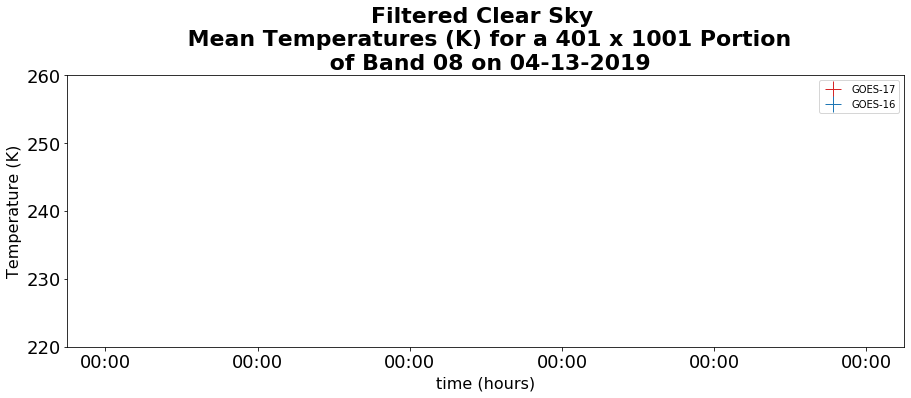

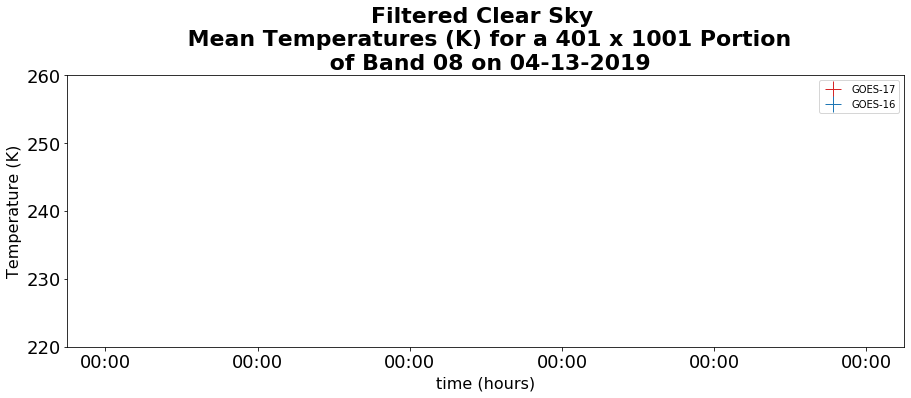

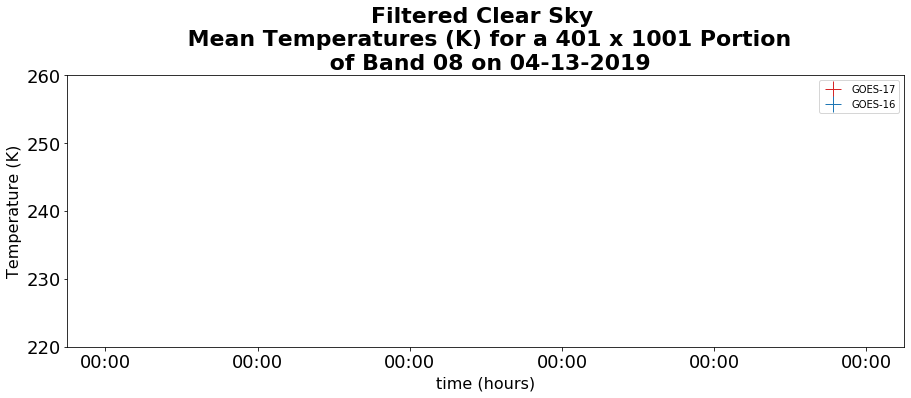

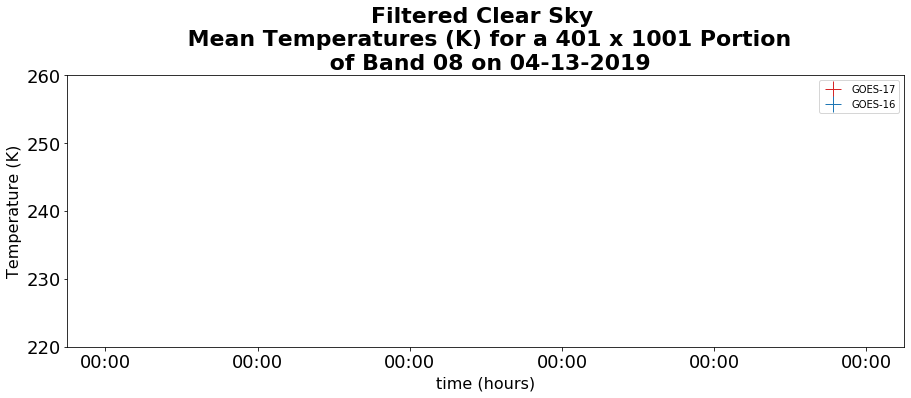

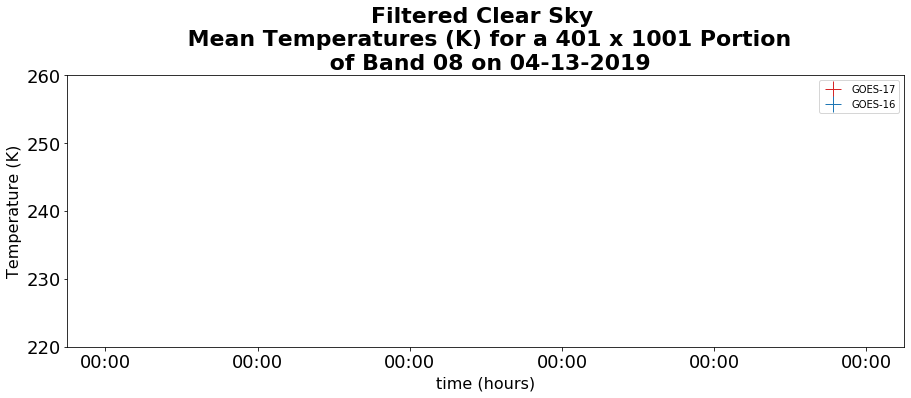

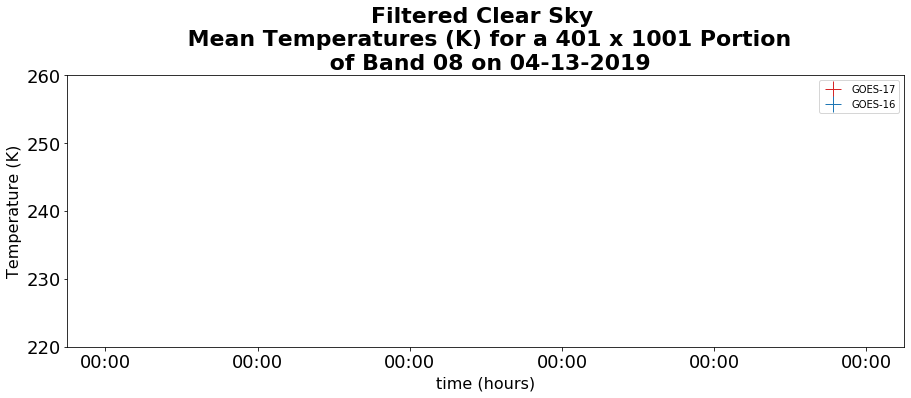

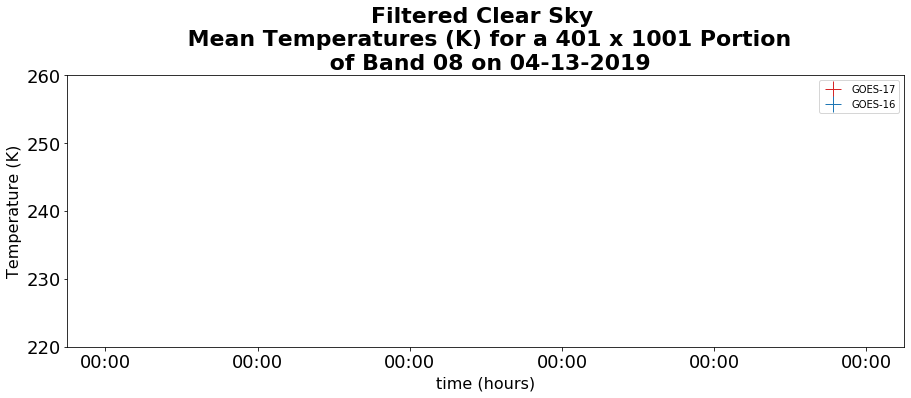

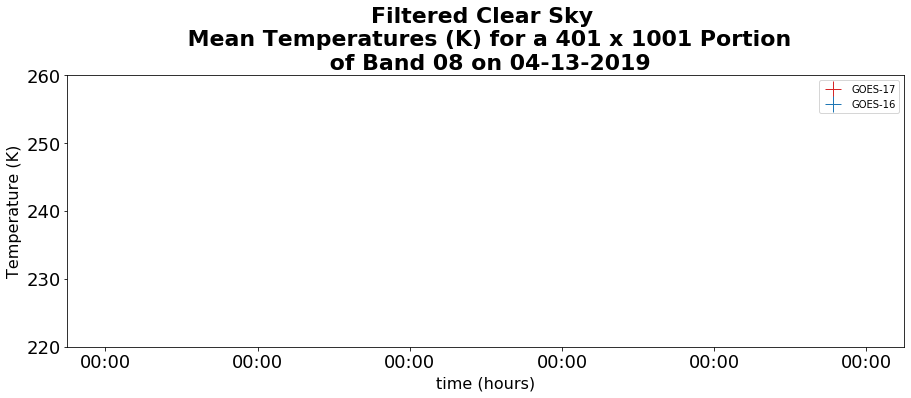

In [22]:


for i in [7]:
    for j in range(11):
        band = str(i).zfill(2)
        day = 90 + j
        day = str(day).zfill(3)
        
        times17, mean17 = getTmean('17', npPath, band, day)
        times16, mean16 = getTmean('16', npPath, band, day)
        
        ptimes17 = [datetime.strptime(f"2019{day}{t}", "%Y%j%H%M") for t in times17]
        ptimes16 = [datetime.strptime(f"2019{day}{t}", "%Y%j%H%M") for t in times16]
        fig1, ax1 = plt.subplots(figsize=(15,5), constrained_layout=False)
        _ = ax1.plot_date(ptimes17, mean17 , label="GOES-17", color='tab:red', marker='+', markersize = 16)
        _ = ax1.plot_date(ptimes16, mean16 , label='GOES-16', color='tab:blue', marker='+', markersize = 16, zorder=-1)
        _ = ax1.set_ylim(220,260)
        _ = ax1.tick_params('both', labelsize=18)
        _ = ax1.legend()
        _ = ax1.set_title('Filtered Clear Sky \n Mean Temperatures (K) for a 401 x 1001 Portion\n of Band 08 on 04-13-2019', fontweight ='bold', fontsize = 22)
        _ = ax1.set_ylabel('Temperature (K)',fontsize = 16)
        _ = ax1.set_xlabel('time (hours)',fontsize = 16)
        _ = ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

In [11]:
np.version.version

'1.16.4'

In [9]:
!conda install --channel "conda-forge" numpy==1.16.2 -y

Using Anaconda Cloud api site https://api.anaconda.org
Fetching package metadata .........
Solving package specifications: ..........

# All requested packages already installed.
# packages in environment at /opt/home/adomakor412/.conda/envs/GOESCode:
#
numpy                     1.16.2           py37h8b7e671_1    conda-forge
